## Assignment for Module 6

In this assignment you will continue working with the housing price per district from the previous module assignment, this time training SVM models, both for regression and classification.

#### Getting the data for the assignment (similar to the notebook from chapter 2 of Hands-On...)

In [1]:
import os
import tarfile
from six.moves import urllib
import numpy as np

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [2]:
fetch_housing_data()

In [3]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [5]:
housing = load_housing_data()
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


### Fix the categories in the categorical variable

In [ ]:
d = {'<1H OCEAN':'LESS_1H_OCEAN', 'INLAND':'INLAND', 'ISLAND':'ISLAND', 'NEAR BAY':'NEAR_BAY', 'NEAR OCEAN':'NEAR_OCEAN'}
housing['ocean_proximity'] = housing['ocean_proximity'].map(lambda s: d[s])

### Add 2 more features

In [ ]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["population_per_household"]=housing["population"]/housing["households"]

### Fix missing data

In [ ]:
median = housing["total_bedrooms"].median()
housing["total_bedrooms"].fillna(median, inplace=True) 

### Create dummy variables based on the categorical variable

In [ ]:
one_hot = pd.get_dummies(housing['ocean_proximity'])
housing = housing.join(one_hot)
housing = housing.drop(['ocean_proximity','NEAR_OCEAN'], axis=1)

### Check the data

In [ ]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   longitude                 20640 non-null  float64
 1   latitude                  20640 non-null  float64
 2   housing_median_age        20640 non-null  float64
 3   total_rooms               20640 non-null  float64
 4   total_bedrooms            20640 non-null  float64
 5   population                20640 non-null  float64
 6   households                20640 non-null  float64
 7   median_income             20640 non-null  float64
 8   median_house_value        20640 non-null  float64
 9   rooms_per_household       20640 non-null  float64
 10  population_per_household  20640 non-null  float64
 11  INLAND                    20640 non-null  uint8  
 12  ISLAND                    20640 non-null  uint8  
 13  LESS_1H_OCEAN             20640 non-null  uint8  
 14  NEAR_B

### Partition into train and test

Use train_test_split from sklearn.model_selection to partition the dataset into 70% for training and 30% for testing.

You can use the 70% for training set as both training and validation by using cross-validation.


In [ ]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.3, random_state=42)

### Features

In [ ]:
target = 'median_house_value'
features = list(train_set.columns)
features = [f for f in features if f!=target]

In [ ]:
X_tr = train_set[features]
y_tr = train_set[[target]]

X_te = test_set[features]
y_te = test_set[[target]]

In [ ]:
#Capture all the categorical features in a list.
column_Categorical = ['INLAND','ISLAND','LESS_1H_OCEAN','NEAR_BAY']
column_Numerical = [col for col in features if col not in column_Categorical]

### Bulding Data Pipeline using Feature Union (using Column instead of index)

Similarly, use StandardScaler from sklearn.preprocessing to normalize the training and testing data, using the training data

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(column_Numerical)),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(column_Categorical))
    ])


from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline),    
    
    ])

X_train = full_pipeline.fit_transform(X_tr)
X_test = full_pipeline.transform(X_te)

#### Comparing models

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import numpy as np

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())

### Linear regression on original features (no transformations) --- benchmark

In [ ]:
from sklearn.linear_model import LinearRegression
lin_scores = cross_val_score(LinearRegression(), train_set[features], train_set[target], scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [71638.62205417 68369.59766399 67555.56882232 67668.00470579
 68568.29042969 66325.04204759 65360.8224899  70215.41434329
 74926.32255192 68989.18585777]
Mean: 68961.68709664335


### 1. Support Vector Machines for Regression

#### (a) In this exercise your goal is to tune SVR with RBF kernel, and make the average score mean_squared_error over 3-folds (cv=3) below 58000. 

You are encouraged to try optimizing any of the hyper-parameters of SVR

See http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html for more details

However, as a hint, you can focus on C and gamma. 

Hint 2: if when you try different values for a hyper-parameter, the optimal models corresponds to one of the extreme values in your range, that probably means you can keep improving your solution by considering values beyond the current range.



In [ ]:
from sklearn.svm import SVR

C_vals = [50,150,300]
gamma_vals = [0.05, 0.10,0.15]

param_grid = [{'C':C_vals, 'gamma':gamma_vals}]
grid_search_rbf = GridSearchCV(SVR(kernel='rbf'), param_grid, cv=3,scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
grid_search_rbf.fit(X_train, np.ravel(y_tr))

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  2.9min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid=[{'C': [50, 150, 300], 'gamma': [0.05, 0.1, 0.15]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=2)

In [ ]:
print(grid_search_rbf.best_params_)
print(np.sqrt(-grid_search_rbf.best_score_))

{'C': 300, 'gamma': 0.05}
86988.29174311661


### Performance on Test Set for SVR

In [ ]:
from sklearn.metrics import mean_squared_error

final_model = grid_search_rbf.best_estimator_   ## THIS SHOULD BE THE BEST GRID_SEARCH ##

y_te_estimation = final_model.predict(X_test)

final_mse = mean_squared_error(y_te, y_te_estimation)
final_rmse = np.sqrt(final_mse)
print(final_rmse)

81077.99153611588


In [ ]:
#Flatten y_te for the graph
y_te = y_te.values.flatten()

In [ ]:
import matplotlib.pyplot as plt

import plotly.graph_objects as go
fig = go.Figure(data=go.Scattergl(
    x=y_te, y=y_te_estimation,
    mode='markers',
    marker=dict(
        color = y_te_estimation,
        size = 5,
        coloraxis="coloraxis")
))
fig.update_yaxes(title_text="Predicted Values")
fig.update_xaxes(title_text="Actual Values")
fig.update_layout(
    autosize=False,
    width=1000,
    height=800,
    title_text="Predicted vs Actual Housing Prices",
coloraxis=dict(colorscale='Viridis'))
fig.update_traces(hovertemplate='Actual: %{x} <br> Predicted: %{y}') 
fig.show()

**Now lets compare the a performance of SVR with Actual Y and Log Transformation Y variable (will this improve the RMSE?)**

In [ ]:
y_ltr = np.log(y_tr)
y_lte = np.log(y_te)

In [ ]:
y_tr

,median_house_value
7061,193800.0
14689,169700.0
17323,259800.0
10056,136100.0
15750,500001.0
...,...
11284,229200.0
11964,97800.0
5390,222100.0
860,283500.0


In [ ]:
y_ltr

,median_house_value
7061,12.174582
14689,12.041787
17323,12.467667
10056,11.821145
15750,13.122365
...,...
11284,12.342350
11964,11.490680
5390,12.310883
860,12.554967


In [ ]:
from sklearn.svm import SVR #- Takes 60 min on training

C_vals = [50,150,300]
gamma_vals = [0.05, 0.10,0.15]

param_grid = [{'C':C_vals, 'gamma':gamma_vals}]
grid_search_rbf = GridSearchCV(SVR(kernel='rbf'), param_grid, cv=3,scoring='neg_mean_squared_error', verbose=2)
grid_search_rbf.fit(X_train, np.ravel(y_ltr))

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] C=50, gamma=0.05 ................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................. C=50, gamma=0.05, total=  28.4s
[CV] C=50, gamma=0.05 ................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   28.4s remaining:    0.0s


[CV] ................................. C=50, gamma=0.05, total=  28.4s
[CV] C=50, gamma=0.05 ................................................
[CV] ................................. C=50, gamma=0.05, total=  28.8s
[CV] C=50, gamma=0.1 .................................................
[CV] .................................. C=50, gamma=0.1, total=  45.5s
[CV] C=50, gamma=0.1 .................................................
[CV] .................................. C=50, gamma=0.1, total=  43.9s
[CV] C=50, gamma=0.1 .................................................
[CV] .................................. C=50, gamma=0.1, total=  45.3s
[CV] C=50, gamma=0.15 ................................................
[CV] ................................. C=50, gamma=0.15, total= 1.0min
[CV] C=50, gamma=0.15 ................................................
[CV] ................................. C=50, gamma=0.15, total= 1.0min
[CV] C=50, gamma=0.15 ................................................
[CV] .

[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed: 63.3min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [50, 150, 300], 'gamma': [0.05, 0.1, 0.15]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=2)

In [ ]:
#1st Model Insights
print(grid_search_rbf.best_params_)
print(np.sqrt(-grid_search_rbf.best_score_))

{'C': 50, 'gamma': 0.1}
0.261867365157418


In [ ]:
#first Model
from sklearn.metrics import mean_squared_error

final_model = grid_search_rbf.best_estimator_   ## THIS SHOULD BE THE BEST GRID_SEARCH ##

y_lte_estimation = final_model.predict(X_test)

final_mse = mean_squared_error(y_lte, y_lte_estimation)
final_rmse = np.sqrt(final_mse)
print(final_rmse)

0.2550378909095587


Lets Compare the first Prediction vs Actual for First Model (without Log)

In [ ]:
# Actual value
Actual = y_te[:1]
print(Actual)

[47700.]


In [ ]:
#Prediction without the log
Prediction_Without_Log = y_te_estimation[0]
print(Prediction_Without_Log)

69204.53568110574


In [ ]:
#Prediction with Log
y_lte_estimation = np.exp(y_lte_estimation)
Prediction_Without_Log = y_lte_estimation[0]
print(Prediction_Without_Log)

48080.97334470886


As a result of applying Log Transformation, You can see the Actual Value (47700) is much closer to Log - Exp Transformed prediction (48757.71) compared to default prediction (57848.334)

### 2. SVM for Classification

Now we transform the continuous target into a binary variable, and try a classification model, that will predict whether or not the price is above the average $179700


In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
np.median(housing[['median_house_value']])

179700.0

#### Binary target variable

In [ ]:
y_tr_b = 1*np.ravel(y_tr>=179700.0)
y_te_b = 1*np.ravel(y_te>=179700.0)

In [ ]:
y_te_b

array([0, 0, 1, ..., 1, 0, 1])

#### Linear SVC for classification

In [ ]:
from sklearn.svm import LinearSVC

In [ ]:
lin_clf = LinearSVC(C=1e-5, random_state=42)
lin_clf.fit(X_train, y_tr_b)

LinearSVC(C=1e-05, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
          verbose=0)

In [ ]:
y_pred = lin_clf.predict(X_train)
accuracy_score(y_tr_b, y_pred)

0.7953349944629015

In [ ]:
# Calculate the Accuracy
y_pred_test = lin_clf.predict(X_test)
accuracy_score(y_te_b, y_pred_test)

0.7965116279069767

### (a) Does SVC (with default hyper-parameters) improve the performance of the linear SVC?

In [ ]:
from sklearn.svm import SVC

In [ ]:
SVC_Classifier = SVC(random_state = 42)
SVC_Classifier.fit(X_train, y_tr_b)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [ ]:
#get training accuracy

y_pred_SVC_Classifier = SVC_Classifier.predict(X_train)
accuracy_score(y_tr_b, y_pred_SVC_Classifier)

0.8690476190476191

In [ ]:
#get the accuracy score for test set

y_pred_te_SVC_Classifier = SVC_Classifier.predict(X_test)
accuracy_score(y_te_b, y_pred_te_SVC_Classifier)

0.8640180878552972

### (b) Use randomized search to tune hyper-parameters of SVC and improve its performance

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

In [ ]:
param_distributions = {"gamma": reciprocal(0.05,0.15), "C": uniform(50,300)}
rnd_search_cv = RandomizedSearchCV(SVC_Classifier, param_distributions, n_iter=10, n_jobs=-1, verbose=2)
rnd_search_cv.fit(X_train, y_tr_b)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  5.5min finished


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                                 class_weight=None, coef0=0.0,
                                 decision_function_shape='ovr', degree=3,
                                 gamma='scale', kernel='rbf', max_iter=-1,
                                 probability=False, random_state=42,
                                 shrinking=True, tol=0.001, verbose=False),
                   iid='deprecated', n_iter=10, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fb7ff037050>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fb7ff02c950>},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=2)

In [ ]:
#Get the best estimator on Randomized SearchCV
rnd_search_cv.best_estimator_

SVC(C=315.04019238259167, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3,
    gamma=0.07192739553937967, kernel='rbf', max_iter=-1, probability=False,
    random_state=42, shrinking=True, tol=0.001, verbose=False)

In [ ]:
#Get the best Score.
rnd_search_cv.best_score_

0.877352611803991

In [ ]:
#get the accuracy score on Random Search CV
y_pred_rnd_Classifier = rnd_search_cv.predict(X_train)
accuracy_score(y_tr_b, y_pred_rnd_Classifier)

0.9051771871539314

In [ ]:
FinalModel_Randomized_Search = rnd_search_cv.best_estimator_   ## THIS SHOULD BE THE BEST GRID_SEARCH ##

y_te_FinalModel = FinalModel_Randomized_Search.predict(X_test)
accuracy_score(y_te_b, y_te_FinalModel)

0.8746770025839793

This indicates that the model fits very well on the test data. To check the overall fit, The code below shows the learning curve on the best parameters.

<pre>
SVC(C=315.04019238259167, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3,
    gamma=0.07192739553937967, kernel='rbf', max_iter=-1, probability=False,
    random_state=42, shrinking=True, tol=0.001, verbose=False)
</pre>

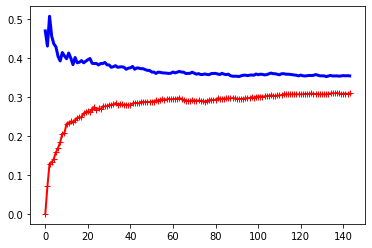

In [ ]:
#draw the learning curve on the best estimator.

svc_randomized = rnd_search_cv.best_estimator_

train_errors, val_errors = [], []
for m in range(100, len(X_train), 100):
    svc_randomized.fit(X_train[:m], y_tr_b[:m]) # DO NOT DELETE
    y_train_predict = svc_randomized.predict(X_train[:m])
    y_val_predict = svc_randomized.predict(X_test[:m])
    train_errors.append(mean_squared_error(y_train_predict, y_tr_b[:m]))
    val_errors.append(mean_squared_error(y_val_predict, y_te_b[:m]))
    
plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
plt.show()